## Zero-Shot Mutation Effect Prediction with ESM-2

Protein function depends on its amino acid sequence, and even one change can alter activity, stability, or binding. Traditional methods to study these effects are costly and slow. ESM-2 offers a faster alternative, predicting mutation impacts from sequence alone. Trained on millions of proteins with masked language modeling, it learns which substitutions preserve function and stability from evolutionary patterns.

In this notebook, we'll be scoring mutations, meaning we will quantify how much each amino acid change is predicted to affect the protein’s function or stability.

To score a mutation, we:
1. **Mask** the position of interest in the protein sequence
2. **Predict** probabilities for all 20 amino acids at that position  
3. **Compare** the probabilities of the wild-type vs. mutant amino acid
4. **Calculate** a log-likelihood ratio (LLR) score

**Negative scores** indicate deleterious mutations (model assigns lower probability to the mutant), while **positive scores** suggest beneficial or neutral changes.

We'll demonstrate mutation effect prediction using **β-lactamase TEM from *E. coli***, a clinically important antibiotic resistance enzyme. This protein hydrolyzes β-lactam antibiotics and is one of the most common resistance mechanisms in clinical isolates. TEM-1 was extensively characterized through deep mutational scanning by [Stiffler et al. (2015)](https://www.cell.com/fulltext/S0092-8674%2815%2900078-1), who measured the fitness effects of nearly 5,000 single amino acid mutations. We'll use their experimental data to validate our ESM-2 predictions and demonstrate how well the model captures functional constraints.


### Setup

Here we import all neccessary libraries.

In [ ]:
import mlx.core as mx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from tqdm.auto import tqdm
import pandas as pd
from scipy.stats import spearmanr

Download the experimental deep mutational scanning dataset from Stiffler et al. (2015) for validation of our predictions.

In [3]:
!mkdir -p data
!curl -o data/BLAT_ECOLX_Ranganathan2015.csv https://raw.githubusercontent.com/facebookresearch/esm/refs/heads/main/examples/variant-prediction/data/BLAT_ECOLX_Ranganathan2015.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1693k  100 1693k    0     0  7621k      0 --:--:-- --:--:-- --:--:-- 7630k


Load the ESM-2 model. Here we will use the 650M parameter version. Change the path below to point to your converted checkpoint.

In [4]:
import sys
sys.path.append("..")

from esm import ESM2

esm_checkpoint = "../checkpoints/mlx-esm2_t12_35M_UR50D"
tokenizer, model = ESM2.from_pretrained(esm_checkpoint)

Here we define the mature TEM-1 β-lactamase sequence (263 amino acids, signal peptide removed) and coordinate conversion constants for mapping between UniProt numbering and our sequence indices.

In [5]:
UNIPROT_START_OF_MATURE = 24

sequence = (
    "HPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW"
)

amino_acids = list("ACDEFGHIKLMNPQRSTVWY")


### Function Definitions

These functions handle coordinate conversion between UniProt numbering (which includes the signal peptide) and our mature sequence indices, enabling us to map experimental data positions to the correct sequence locations.

In [6]:
def u2m0(u_pos):
    """Convert UniProt position (1-based) to 0-based index into mature sequence."""
    m0 = u_pos - UNIPROT_START_OF_MATURE
    return m0 if 0 <= m0 else None

def urange_to_m0_span(u_start_incl, u_end_incl):
    """Convert UniProt range to [start, end) mature 0-based slice."""
    s0 = u2m0(u_start_incl)
    e0 = u2m0(u_end_incl)
    if s0 is None: s0 = 0
    if e0 is None: e0 = -1
    s0 = max(0, s0)
    e0 = min(len(sequence) - 1, e0)
    if s0 > e0:
        return None
    return s0, e0 + 1


These are the core mutation scoring functions that implement ESM-2's masked language modeling approach. They mask a position in the sequence, predict amino acid probabilities using the model, and calculate log-likelihood ratios (LLR) comparing mutant versus wild-type amino acids.

In [7]:
def get_site_log_probs(m0_pos):
    """Get log probabilities for all amino acids at a masked position."""
    tokens = tokenizer.encode(sequence)
    input_ids = mx.array(tokens).reshape(1, -1)
    masked = mx.array(input_ids)
    masked[0, m0_pos + 1] = tokenizer.mask_id
    logits = model(masked)["logits"]
    return mx.log(mx.softmax(logits[0, m0_pos + 1], axis=-1))

def score_mutation_llr(u_pos, wt_aa, mut_aa):
    """Calculate log-likelihood ratio for a specific mutation."""
    m0 = u2m0(u_pos)
    if m0 is None or m0 >= len(sequence):
        return np.nan
    
    log_probs = get_site_log_probs(m0)
    wt_tok = tokenizer.token_to_id.get(wt_aa, tokenizer.unk_id)
    mt_tok = tokenizer.token_to_id.get(mut_aa, tokenizer.unk_id)
    return float(log_probs[mt_tok].item() - log_probs[wt_tok].item())

def score_position_llrs(m0_pos):
    """Get LLR scores for all 20 amino acids at a given position."""
    log_probs = get_site_log_probs(m0_pos)
    wt = sequence[m0_pos]
    wt_token = tokenizer.token_to_id.get(wt, tokenizer.unk_id)
    wt_lp = float(log_probs[wt_token].item())
    
    scores = np.zeros(len(amino_acids), dtype=float)
    for i, aa in enumerate(amino_acids):
        mt_tok = tokenizer.token_to_id.get(aa, tokenizer.unk_id)
        scores[i] = float(log_probs[mt_tok].item()) - wt_lp
    return scores


This function generates a mutation effect heatmap for a specified protein region. It calculates LLR scores for all 20 amino acids at each position within the given UniProt range, creating a matrix that visualizes the predicted functional impact of every possible single amino acid substitution.

In [8]:
def generate_heatmap(u_start_incl, u_end_incl):
    """Generate mutation effect heatmap for a UniProt range."""
    span = urange_to_m0_span(u_start_incl, u_end_incl)
    if span is None:
        raise ValueError("Requested UniProt window lies outside the mature sequence.")
    
    s0, e0 = span
    n_cols = e0 - s0
    heatmap = np.zeros((len(amino_acids), n_cols), dtype=float)
    
    print(f"Calculating mutation effects for UniProt {u_start_incl}-{u_end_incl} ")
    
    for j, m0 in enumerate(tqdm(range(s0, e0), desc="Positions")):
        heatmap[:, j] = score_position_llrs(m0)
    
    seq_segment = sequence[s0:e0]
    u_positions = list(range(UNIPROT_START_OF_MATURE + s0, UNIPROT_START_OF_MATURE + e0))
    
    return heatmap, seq_segment, u_positions


This function generates a heatmap visualizing the predicted impact of all possible amino acid substitutions at each position, highlighting regions or residues of interest and coloring them by their log-likelihood ratio scores.

In [9]:
def plot_heatmap(heatmap, seq_seg, u_positions, title,
                col_width=0.42, min_width=8.0, max_width=16.0, height=6.0, dpi=160,
                robust=True, lo=2, hi=98, vmin=None, vmax=None,
                highlight=None, box_color="black", box_lw=3.0, tick_fs=9, aa_fs=11):
    """Plot mutation effect heatmap."""
    
    n_cols = len(seq_seg)
    width = np.clip(col_width * n_cols, min_width, max_width)
    
    if robust and (vmin is None or vmax is None):
        vals = heatmap[np.isfinite(heatmap)]
        if vals.size:
            p_lo, p_hi = np.percentile(vals, [lo, hi])
            vmin = p_lo if vmin is None else vmin
            vmax = p_hi if vmax is None else vmax
    if vmin is None: vmin = -10
    if vmax is None: vmax = 10
    
    fig, ax = plt.subplots(figsize=(width, height), constrained_layout=True, dpi=dpi)
    im = ax.imshow(heatmap, cmap="RdBu_r", aspect="auto", vmin=vmin, vmax=vmax)
    
    ax.set_xticks(range(n_cols))
    ax.set_xticklabels([f"{aa}{u}" for aa, u in zip(seq_seg, u_positions)],
                      rotation=90, fontsize=tick_fs)
    ax.set_yticks(range(len(amino_acids)))
    ax.set_yticklabels(amino_acids, fontsize=aa_fs)
    
    ax.set_xlabel("Wild-type Residue and Position", fontsize=12)
    ax.set_ylabel("Mutant Amino Acid", fontsize=12)
    ax.set_title(title, fontsize=14)
    
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=tick_fs)
    cbar.set_label("Log-Likelihood Ratio", fontsize=11)
    
    if highlight:
        if not isinstance(highlight, (list, tuple, set)):
            highlight = list(highlight)
        u2col = {u: j for j, u in enumerate(u_positions)}
        for u in highlight:
            j = u2col.get(int(u), None)
            if j is not None:
                ax.add_patch(Rectangle((j - 0.5, -0.5), 1.0, heatmap.shape[0],
                                     fill=False, edgecolor=box_color, linewidth=box_lw))
    
    plt.show()
    return fig

### Generating Heatmaps

#### SxxK motif

We start with the SxxK catalytic motif, a signature sequence found in Class A β-lactamases. The highlighted serine (S68) forms a covalent acyl-enzyme intermediate with the β-lactam substrate, while the lysine (K71) plays a crucial role in the catalytic mechanism. This region should show strong purifying selection, with most mutations being highly deleterious, making it an excellent test of whether ESM-2 captures functional constraints.

Calculating mutation effects for UniProt 60-80 


Positions: 100%|██████████| 21/21 [00:00<00:00, 72.60it/s]


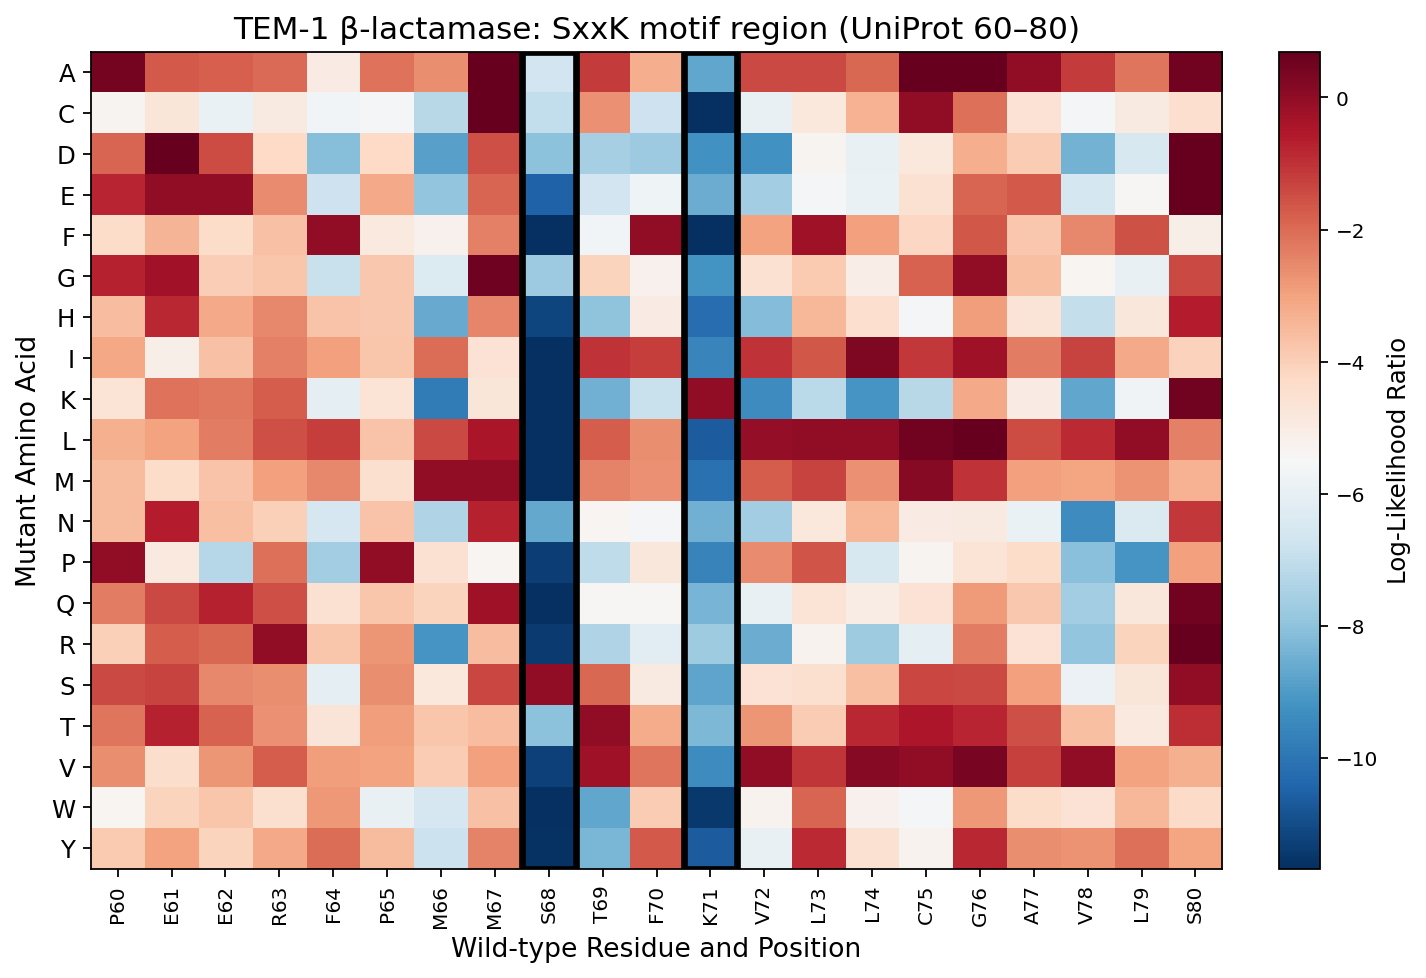

In [10]:
hm1, seg1, upos1 = generate_heatmap(60, 80)
fig1 = plot_heatmap(
    hm1, seg1, upos1,
    title="TEM-1 β-lactamase: SxxK motif region (UniProt 60–80)",
    highlight=[68, 71]
)

The heatmap highlights ESM-2’s ability to pinpoint functionally critical residues. The catalytic serine (S68) and lysine (K71) exhibit extremely negative scores, nearing -10, indicating that almost any substitution at these sites would severely impair enzyme function. In contrast, surrounding positions display a broader range of tolerance, with some accommodating conservative changes. This pattern shows that ESM-2 has captured the precise functional constraints of the active site purely from evolutionary sequence patterns.

#### Binding patch

We next examine the substrate-binding residues 232–234, which form part of the binding patch that interacts directly with the β-lactam substrate. These residues are key to substrate recognition, making them an ideal test of ESM-2’s ability to detect the functional importance of specific contact points.

Calculating mutation effects for UniProt 226-238 


Positions: 100%|██████████| 13/13 [00:00<00:00, 78.58it/s]


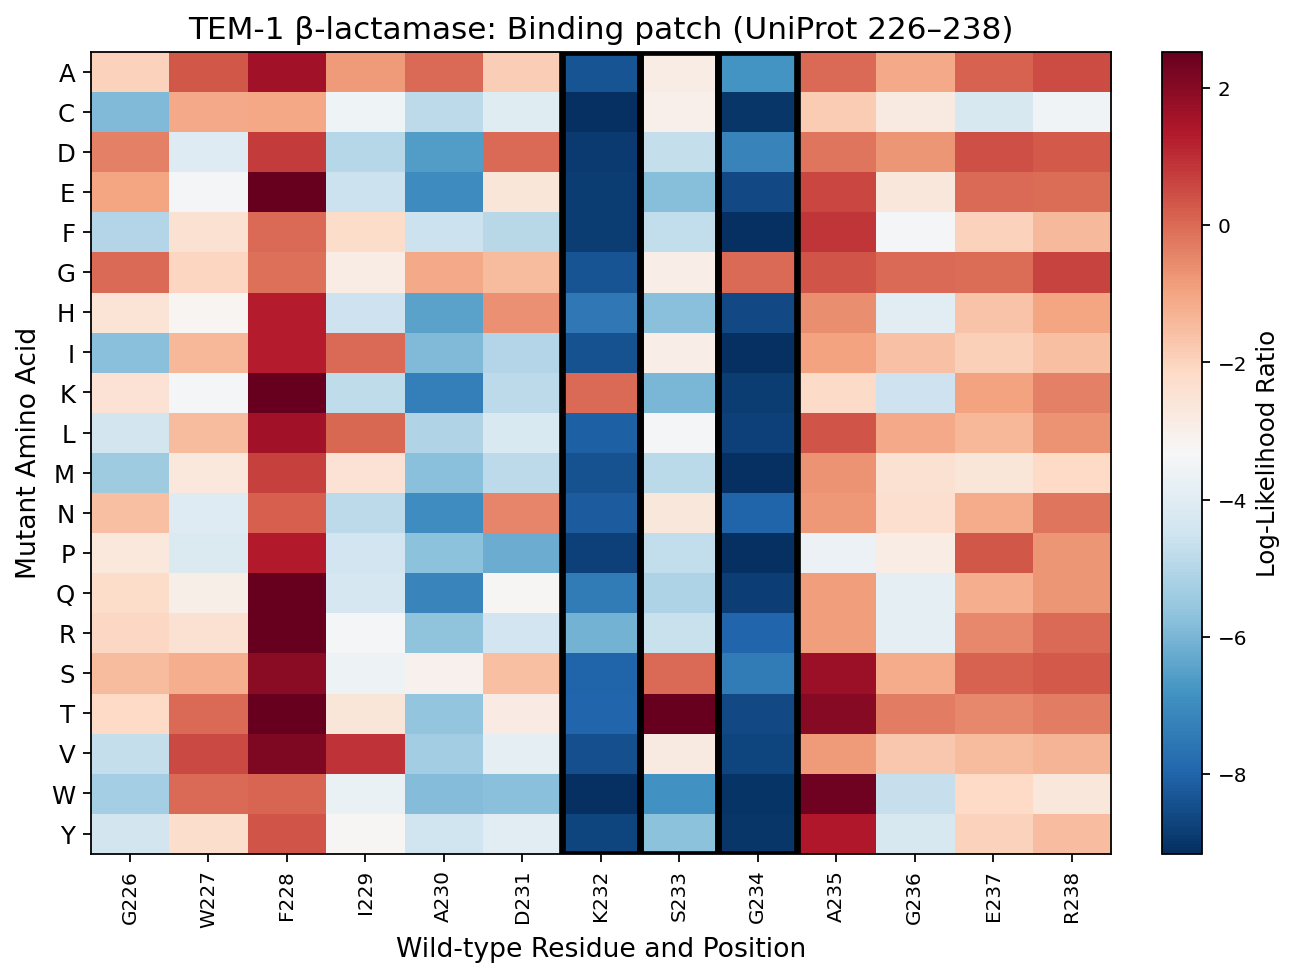

In [11]:
hm2, seg2, upos2 = generate_heatmap(226, 238)
fig2 = plot_heatmap(
    hm2, seg2, upos2,
    title="TEM-1 β-lactamase: Binding patch (UniProt 226–238)",
    highlight=[232, 233, 234]
)


The heatmap illustrates ESM-2’s recognition of the substrate-binding residues 232–234 as critical contact points. All three positions display strongly negative scores, often approaching -10, indicating that nearly any substitution would likely disrupt substrate binding. This sharp contrast with the more variable tolerance observed at neighboring sites suggests that ESM-2 has accurately learned the essential role of these residues in substrate recognition from evolutionary sequence data alone.

####  Ω-loop region

We now focus on the Ω-loop region spanning residues 160–180, which contains the catalytic glutamate at position 166. This residue functions as a proton acceptor during catalysis, playing a central role in the enzyme’s mechanism.

Calculating mutation effects for UniProt 160-180 


Positions: 100%|██████████| 21/21 [00:00<00:00, 76.40it/s]


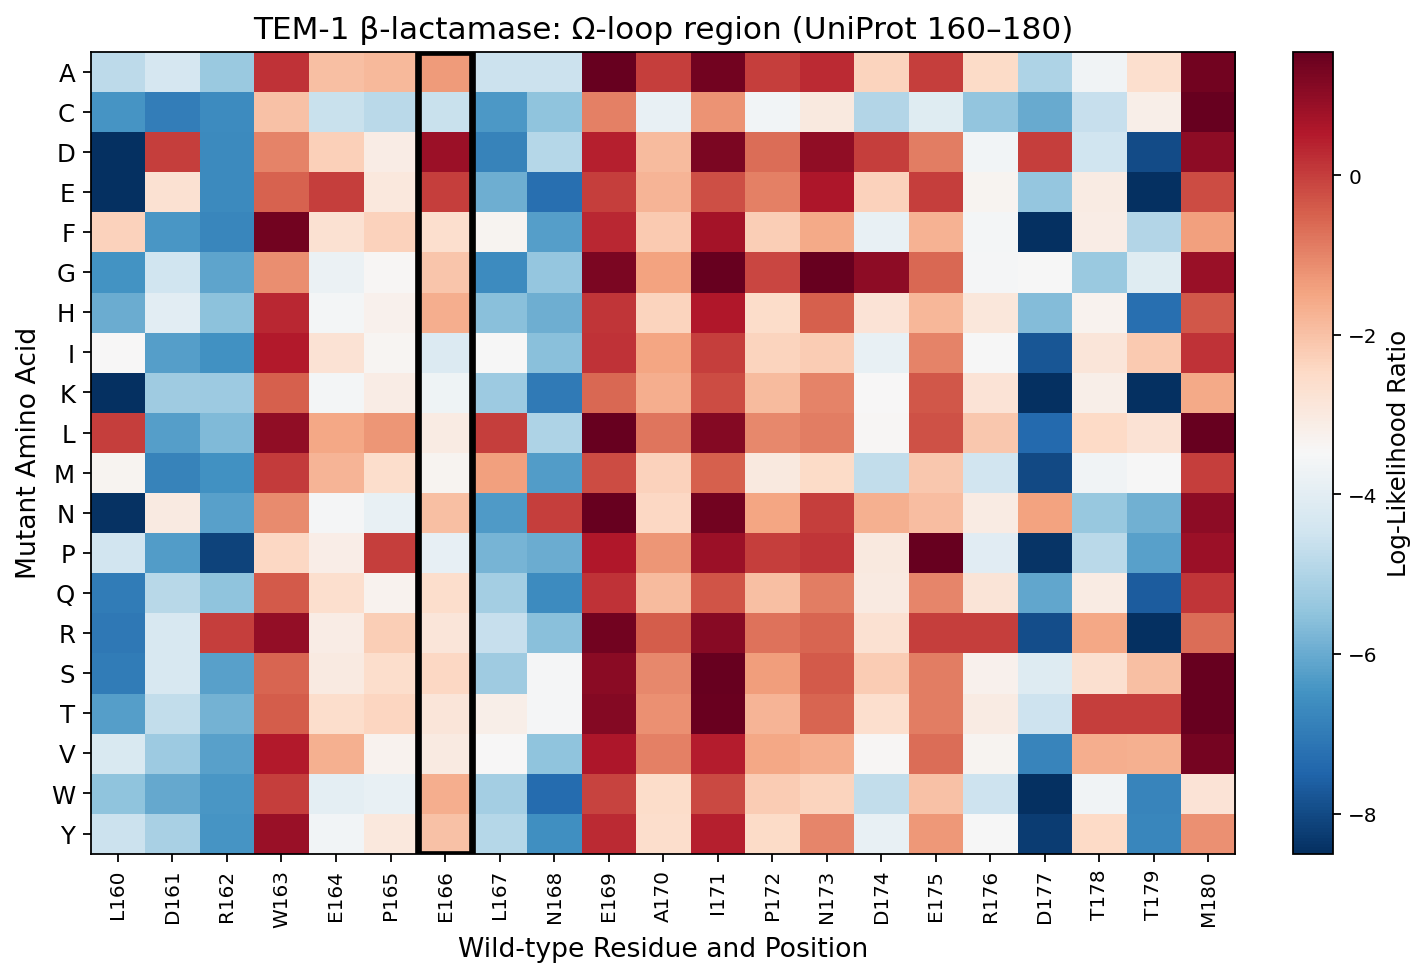

In [12]:
hm3, seg3, upos3 = generate_heatmap(160, 180)
fig3 = plot_heatmap(
    hm3, seg3, upos3,
    title="TEM-1 β-lactamase: Ω-loop region (UniProt 160–180)",
    highlight=[166]
)

The heatmap shows that ESM-2 identifies glutamate 166 as an important catalytic residue, with most substitutions producing negative scores, though generally not as extreme as those seen in the previous examples. This more moderate penalty likely reflects the Ω-loop’s inherent flexibility, which may allow certain substitutions to retain partial function or be accommodated structurally. Additionally, E166’s role as a proton acceptor might be more chemically replaceable than the covalent interactions made by S68 for example, meaning the model does not assign uniformly catastrophic scores to all substitutions.

### DMS Benchmark

This function benchmarks ESM-2’s mutation effect predictions against experimental deep mutational scanning (DMS) data from Stiffler et al. (2015). It takes the list of experimentally measured β-lactamase TEM mutations, scores each with ESM-2 using masked-marginal log-likelihood ratios, and then compares the predicted scores to experimental fitness values across antibiotic concentrations. The correlation analysis, reported as Spearman |ρ|, quantifies how well ESM-2’s sequence-only predictions align with measured resistance phenotypes. This provides a direct test of the model’s ability to capture functional effects observed in large-scale experimental screens.

Loading DMS mutations from data/BLAT_ECOLX_Ranganathan2015.csv...


Scoring DMS mutations: 100%|██████████| 4996/4996 [00:50<00:00, 98.14it/s] 


Spearman |ρ| vs. experimental fitness:
  2500  μg/mL: |ρ| = 0.556
  625   μg/mL: |ρ| = 0.459
  156   μg/mL: |ρ| = 0.393
  39    μg/mL: |ρ| = 0.284
  0     μg/mL: |ρ| = 0.164


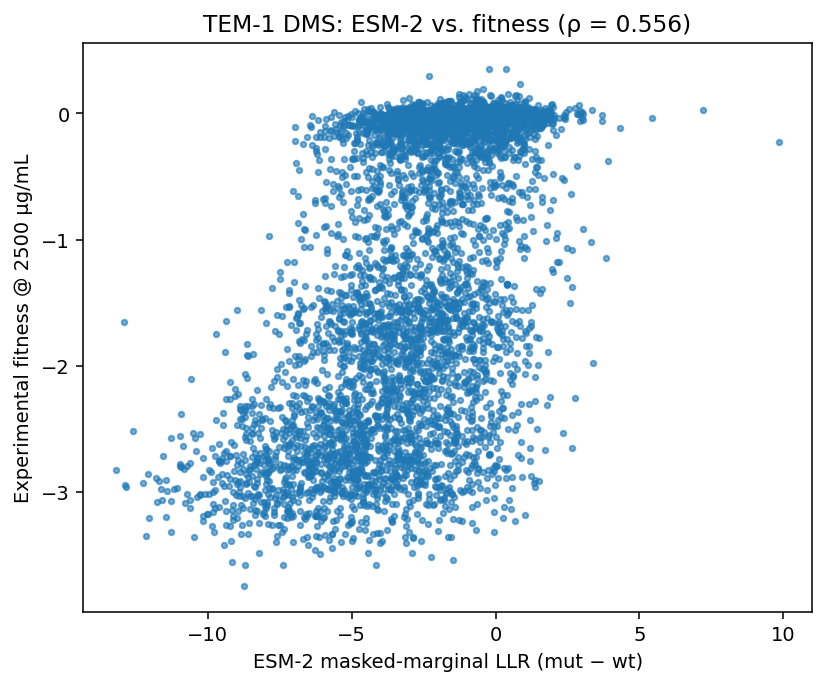

In [13]:
def run_dms_benchmark(csv_path):
    """Compare ESM-2 predictions with experimental DMS data."""
    print(f"Loading DMS mutations from {csv_path}...")
    df = pd.read_csv(csv_path)
    
    preds = []
    for mut in tqdm(df["mutant"], desc="Scoring DMS mutations"):
        wt = mut[0]
        u_pos = int(mut[1:-1])
        mt = mut[-1]
        llr = score_mutation_llr(u_pos, wt, mt)
        preds.append(llr)
    df["esm2_llr"] = preds
    
    exp_cols = [c for c in ["2500", "625", "156", "39", "0"] if c in df.columns]
    if exp_cols:
        print("\nSpearman |ρ| vs. experimental fitness:")
        for col in exp_cols:
            mask = ~(df[col].isna() | df["esm2_llr"].isna())
            if mask.sum() > 0:
                rho = spearmanr(df.loc[mask, "esm2_llr"], df.loc[mask, col])[0]
                print(f"  {col:5} μg/mL: |ρ| = {abs(rho):.3f}")
        
        top_col = None
        for candidate in ["2500", "1250", "1000", "625", "156", "39"]:
            if candidate in exp_cols:
                top_col = candidate
                break
                
        if top_col:
            mask = ~(df[top_col].isna() | df["esm2_llr"].isna())
            x = df.loc[mask, "esm2_llr"].values
            y = df.loc[mask, top_col].values
            
            plt.figure(figsize=(6, 5), dpi=140)
            plt.scatter(x, y, s=8, alpha=0.6)
            plt.xlabel("ESM-2 masked-marginal LLR (mut − wt)")
            plt.ylabel(f"Experimental fitness @ {top_col} μg/mL")
            rho = spearmanr(x, y)[0]
            plt.title(f"TEM-1 DMS: ESM-2 vs. fitness (ρ = {rho:.3f})")
            plt.tight_layout()
            plt.show()
    else:
        print("No experimental concentration columns found.")
    
    return df

dms_df = run_dms_benchmark(
    "data/BLAT_ECOLX_Ranganathan2015.csv",
)

The scatter plot shows a moderate correlation (ρ = 0.556) between ESM-2 predictions and experimental fitness, but the relationship is noisy with substantial variation around the trend. In general, more negative ESM-2 scores tend to correspond to lower experimental fitness, yet many individual mutations deviate from this pattern. Some mutations with highly negative LLR scores still maintain reasonable fitness, while others with only modestly negative scores perform poorly. The increase in correlation strength with higher antibiotic concentration (from |ρ| = 0.164 to |ρ| = 0.556) suggests that ESM-2’s evolutionary-based predictions become more relevant under strong selective pressure. However, even at the highest concentration, the considerable scatter indicates that predicting mutation effects remains challenging and that experimental fitness is influenced by factors beyond what ESM-2 can infer from sequence patterns alone. It's important to note that these results are based on the 35M parameter ESM-2 model, and it is likely that larger models would achieve stronger correlations and improved predictive performance.